In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal


# you can choose one of the following package for image reading/processing
import cv2
import PIL


# Part 1 Support Vector Machine(SVM)

In [ ]:
# Loading Data_Frame
from google.colab import drive
drive.mount('/content/drive/')

x_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Dataset/hw3/x_train.csv', header=None).values
x_train = np.array(x_train)
x_train_0 = x_train[::3]
x_train_1 = x_train[1::3]
x_train_2 = x_train[2::3]
x_train = np.concatenate((x_train_0,
                          x_train_1,
                          x_train_2))
t_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Dataset/hw3/t_train.csv', header=None)
t_train = np.array(t_train)
t_train_0 = t_train[::3]
t_train_1 = t_train[1::3]
t_train_2 = t_train[2::3]
t_train = np.concatenate((t_train_0,
                          t_train_1,
                          t_train_2))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##[1] Use the principal component analysis (PCA) to reduce the dimension of images to d = 2

In [ ]:
class PCA_2D:
  def __init__(self, dim, x_train):
    pca_2d = PCA(n_components=dim)
    self.transformed_data = pca_2d.fit_transform(x_train)
    self.normalization = (self.transformed_data - np.mean(self.transformed_data)) / np.std(self.transformed_data)
    self.components = pca_2d.components_
  
  def get_transformed_data(self):
    return self.transformed_data
  def get_transformed_data_with_normalization(self):
    return self.normalization
  def get_components(self):
    return self.components

In [ ]:
pca_2d = PCA_2D(2, x_train)
x_data = pca_2d.get_transformed_data_with_normalization()
t_data = t_train

##[2] Analyze the difference between two decision approaches (one-versus-the-rest and one- versus-one). Decide which one you want to choose and explain why you choose this approach.

### Answer
1. **One-versus-the-rest** 跟 **One-versus-one** 都是二元分類器應用在多類別問題上的策略。
---
2. **One-versus-the-rest：**選取一類當作+1類，其餘當作-1類，利用二元分類器得到一個decision hyperplane，然後輪流將每一類別都當過+1類。比如：本題有三類，所以在train階段會得到3個分類器，在test階段時，選取三個分類器中分數最高的那一類當作決策。
---
3. **One-versus-one：**一次只做兩個類別的分類，兩兩pk，直到兩兩都配對分類完成。train階段會得到3個分類器，在test階段時，選取得到最多票數的那類當作判斷決策。
---
4. 本次使用One-versus-one的策略，因為SVM在這個策略下比較不會犧牲掉樣本數比較少的類別。

##[3-4] Use the principle values projected to top two eigenvectors obtained from PCA, and build a SVM with linear kernel to do multi-class classification. Then, plot the corresponding decision boundary and show the support vector.

In [ ]:
class Kernel:
    def __init__(self, mode='Linear') -> None:
      self.mode = mode
      self.phi = self.create_phi

    def create_phi(self, x):
      if self.mode == 'Linear':
          phi = x
      elif self.mode == 'Polynomial':
          if len(x.shape) == 1:
            x = x.reshape(1,2)
          phi = np.vstack((x[:,0]**2, 
                           np.sqrt(2)*x[:,0]*x[:,1], 
                           x[:,1]**2)).T
      return phi
    
    def kernel_function(self, x1, x2):
      return self.phi(x1) @ self.phi(x2).T

In [ ]:
class Utils:
  def __init(self) -> None:
    pass
  def most_common(self, lst):
    return max(set(lst), key=lst.count)

In [ ]:
class SVM:
    def __init__(self, mode='Linear', C=1):
      self.mode = mode
      self.C = C
      self.kernel = Kernel(mode)
      self.utils = Utils()
      self.class_label = [(0, 1), (0, 2), (1, 2)]
      self.coeff = None
      self.sv_index = None

    def fit(self, x, t):
      from sklearn import svm
      if self.mode == 'Linear':
        classifier = svm.SVC(kernel='linear', 
                             C=self.C, 
                             decision_function_shape='ovo')
      elif self.mode == 'Polynomial':
        classifier = svm.SVC(kernel='poly', 
                             C=self.C, 
                             degree=2, 
                             decision_function_shape='ovo')
      classifier.fit(x,t)
      self.coeff = np.abs(classifier.dual_coef_)
      self.sv_index = classifier.support_

    def get_param(self, x):
      #target
      target_dict = {}
      # target_dict[(0, 1)] = np.tile((1,-1,0), 100)
      # target_dict[(0, 2)] = np.tile((1,0,-1), 100)
      # target_dict[(1, 2)] = np.tile((0,1,-1), 100)
      target_dict[(0, 1)] = np.concatenate((np.ones(100), 
                                            np.full(100, -1), 
                                            np.zeros(100)))
      target_dict[(0, 2)] = np.concatenate((np.ones(100),
                                            np.zeros(100),
                                            np.full(100, -1)))
      target_dict[(1, 2)] = np.concatenate((np.zeros(100),
                                            np.ones(100),
                                            np.full(100, -1)))
     
      #multiplier
      multiplier = np.zeros([x.shape[0], 2]) #x.shape
      multiplier[self.sv_index] = self.coeff.T

      multiplier_dict = {}
      multiplier_dict[(0, 1)] = np.concatenate((multiplier[:200, 0],
                                                np.zeros(100)))
      multiplier_dict[(0, 2)] = np.concatenate((multiplier[:100, 1],
                                                np.zeros(100),
                                                multiplier[200:, 0]))
      multiplier_dict[(1, 2)] = np.concatenate((np.zeros(100),
                                                multiplier[100:, 1]))
      return target_dict, multiplier_dict

    def get_weight_bias(self, alpha, t, x):
      # get_weight 7.29
      weight = (alpha*t) @ self.kernel.create_phi(x)
      # get_bias 7.37
      M_index = np.where(((alpha > 0) & (alpha < self.C)))[0]
      S_index = np.nonzero(alpha)[0]
      if len(M_index)==0:
        bias = -1
      else:
        bias = np.mean(t[M_index] - (alpha*t)[S_index] @ self.kernel.kernel_function(x[M_index], x[S_index]).T)
      
      return weight, bias

    def train(self, x, t):
      target_dict, multiplier_dict = self.get_param(x)
      
      weight_dict = {}
      bias_dict = {}
      for c1, c2 in self.class_label:
        weight, bias = self.get_weight_bias(multiplier_dict[(c1, c2)], target_dict[(c1, c2)], x)
        weight_dict[(c1, c2)] = weight
        bias_dict[(c1, c2)] = bias
      return weight_dict, bias_dict
  
    def predict(self, x, weight_dict, bias_dict):
      #O2O by voting
      predict_class = []
      for index in range(x.shape[0]):
        votes = []
        for c1, c2 in self.class_label:
          weight = weight_dict[(c1, c2)]
          bias = bias_dict[(c1, c2)]
          y = weight @ self.kernel.create_phi(x[index]).T + bias
          if y > 0:
            votes += [c1]
          else:
            votes += [c2]
        predict_class += [self.utils.most_common(votes)]
      return predict_class
      
    def plot(self, mode, x, t, xx, yy, prediction):
      cls_0_index = np.where(t == 0)[0]
      cls_1_index = np.where(t == 1)[0]
      cls_2_index = np.where(t == 2)[0]
      plt.scatter(x[self.sv_index, 0], x[self.sv_index, 1], facecolors='none', edgecolors='k', linewidths=1.25, label="Support Vector")
      plt.scatter(x[cls_0_index][:, 0], x[cls_0_index][:, 1], c='b', marker='.', label="chinese 0")
      plt.scatter(x[cls_1_index][:, 0], x[cls_1_index][:, 1], c='r', marker='.', label="chinese 1")
      plt.scatter(x[cls_2_index][:, 0], x[cls_2_index][:, 1], c='g', marker='.', label="chinese 4")
      plt.legend()
      plt.contourf(xx, yy, prediction, alpha=0.3, cmap=plt.cm.brg)
      plt.title('%s SVM' % mode, fontsize = 10)
      plt.show()

    def make_meshgrid(self, x, y, h=0.02):
      space = 0.3
      x_min, x_max = x.min() - space, x.max() + space
      y_min, y_max = y.min() - space, y.max() + space
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
      return xx, yy

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


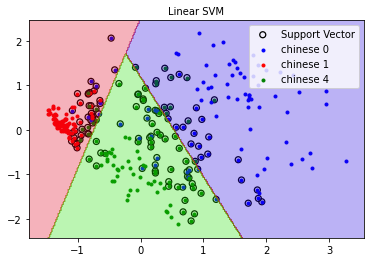

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


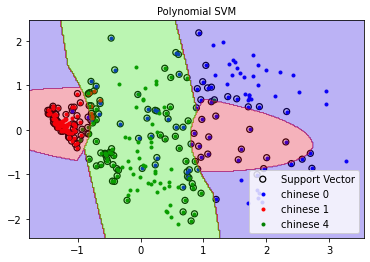

In [ ]:
# [3-4]
kernel_mode = ['Linear', 'Polynomial']
for _mode in kernel_mode:
  model = SVM(mode=_mode)
  model.fit(x_data, 
            t_data)
  weight_dict, bias_dict = model.train(x_data, 
                                       t_data)
  xx, yy = model.make_meshgrid(x_data[:, 0], 
                               x_data[:, 1])
  test_data = np.vstack((xx.flatten(), yy.flatten()))
  predict_class = model.predict(test_data.T,
                                weight_dict,
                                bias_dict)
  model.plot(_mode, 
             x_data, 
             t_data, 
             xx, 
             yy, 
             np.array(predict_class).reshape(xx.shape))

## [5] Please discuss the difference between (3) (4).

### Discussion
1. 由Linear SVM 跟 Polynomial SVM 結果來觀察，可以發現線性的Kernel對於這次的挑選的3個中文字分類表現比較好.
---
2. Polynomial Kernel 跟 Linear Kernel 投影的維度分別是(3, 2)，由結果論這次的分類器利用比較低的維度，也就是2維來分類效果較佳！

# Part 2 Gaussian Mixture Model(GMM)

In [ ]:
# Load image
img_raw = PIL.Image.open('/content/drive/MyDrive/Colab_Notebooks/Dataset/hw3/hw3.jpg')

# Normalize to 0~1
img_norm = np.asarray(img_raw, dtype='float')/255

# Flatten each color to array
height, weight, colors = img_norm.shape
img_array = np.reshape(img_norm, (-1, colors))

##[1] Please build a K-means model by minimizing J loss.

In [ ]:
class K_Means:
  def __init__(self, data, K=3, iteration=100) -> None:
      self.K = K
      self.iteration = iteration
      self.eye = np.eye(K)
      #initialize means and rnk
      self.means = data[np.random.choice(len(data), self.K, replace=False)] # without replacement
      self.rnk = np.ones([len(data), self.K]) #(252150,3)

  def minimize_J_loss(self, data):
    for iter in range(self.iteration):
      error = np.sum((data[:, None] - self.means)**2, axis=2)
      rnk = self.eye[np.argmin(error, axis=1)]

      if np.array_equal(rnk, self.rnk):
        break
      else:
        self.rnk = rnk
      
      #re-calculate k means
      self.means = np.sum(rnk[:, :, None] * data[:, None], axis=0) / np.sum(rnk, axis=0)[:, None]

In [ ]:
def plot_table(model, k, mode):
  if mode == 'K_means':
    mu = (model.means*255).astype(int)
    table = {'R': mu[:, 0], 'G': mu[:, 1], 'B': mu[:, 2]}
    print(mode + ' K = {}'.format(k))
    print(pd.DataFrame.from_dict(table), '\n')
  elif mode == 'GMM':
    mu = (model.mu*255).astype(int)
    table = {'R': mu[:, 0], 'G': mu[:, 1], 'B': mu[:, 2]}
    print(mode + ' K = {}'.format(k))
    print(pd.DataFrame.from_dict(table), '\n')

In [ ]:
def plot_img(model, k, mode):
  if mode == 'K_means':
    new_data = (model.means[np.where(model.rnk == 1)[1]]*255).astype(int)
  elif mode == 'GMM':
    new_data = (model.mu[np.argmax(model.gaussians, axis=0)]*255).astype(int)
  
  plt.title(mode + ' K = {}'.format(k), fontsize = 15)
  plt.imshow(new_data.reshape(height, weight, colors).astype('uint8')), plt.xticks([]), plt.yticks([])
  plt.show()
  


##[2-3]


In [ ]:
class GMM:
  def __init__(self, K, max_iteration=100) -> None:
      self.K = K
      self.max_iteration = max_iteration
      self.likelihood_list = []

  def initialize(self, k_means_rnk, k_means_mu, data): 
      #pi_k = N_k / N
      self.pi = np.sum(k_means_rnk, axis=0)/ len(k_means_rnk)
      self.cov = np.array([ np.cov(data[np.where(k_means_rnk[:, k] == 1)[0]].T) for k in range(self.K) ])
      self.gaussians = np.array([multivariate_normal.pdf(data, mean=k_means_mu[k], cov=self.cov[k])*self.pi[k] for k in range(self.K)])

  def evaluate(self, data, iteration):
      for k in range(self.K):
            try:
                self.gaussians[k] = multivariate_normal.pdf(data, mean=self.mu[k], cov=self.cov[k])*self.pi[k] 
            except np.linalg.linalg.LinAlgError:
                print('singular error at iteration %d' % iteration)
                self.mu[k] = np.random.rand(colors)
                temp = np.random.rand(colors, colors)
                self.cov[k] = temp.dot(temp.T)
                self.gaussians[k] = multivariate_normal.pdf(data, mean=self.mu[k], cov=self.cov[k])*self.pi[k]
            
      self.likelihood_list.append(self.log_likelihood())
  def E_step(self):
      # fixed mu sigma pi -> calculate gamma
      self.gamma = (self.gaussians / np.sum(self.gaussians, axis=0)).T

  def M_step(self, data):
      self.Nk = np.sum(self.gamma, axis=0)
      self.mu = np.sum(self.gamma[:, :, None]*data[:, None], axis=0) / self.Nk[:, None]
      for k in range(self.K):
          self.cov[k] = (self.gamma[:, k, None]*(data - self.mu[k])).T.dot(data - self.mu[k]) / self.Nk[k] + 1e-7 * np.eye(colors)
      self.pi = self.Nk / len(data)

  def EM(self, data):
      for iter in range(self.max_iteration):
          self.E_step()
          self.M_step(data)
          self.evaluate(data, iter)

  def log_likelihood(self):
      return np.sum(np.log(np.sum(self.gaussians, axis=0)))
  def plot_log_likelihood(self):
      plt.title('Log likelihood of GMM (k = %d)' % self.K)
      plt.plot([i for i in range(100)], self.likelihood_list)
      plt.show()

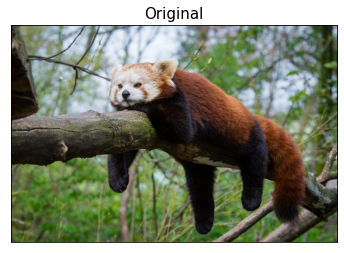

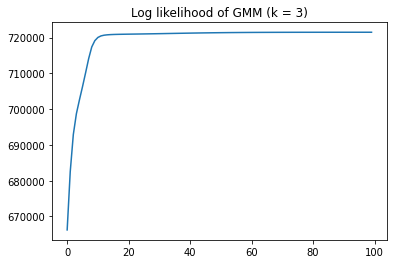

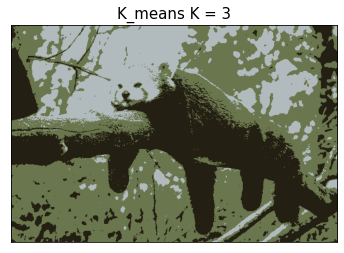

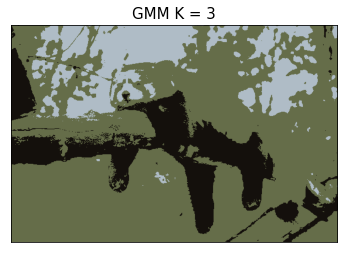

K_means K = 3
     R    G    B
0  177  186  189
1   35   31   18
2  106  118   77 

GMM K = 3
     R    G    B
0  175  188  198
1   20   16   12
2  101  109   73 



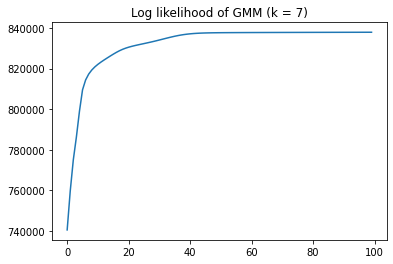

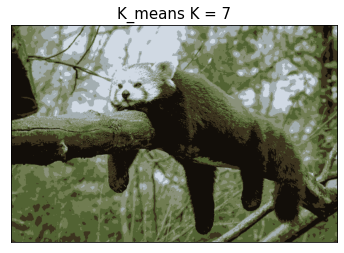

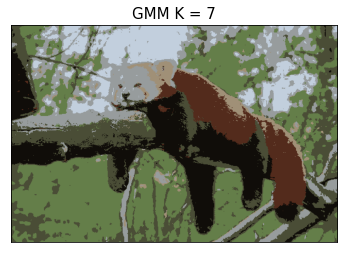

K_means K = 7
     R    G    B
0  112  124   81
1  163  174  177
2   82   99   51
3  208  217  227
4   18   14    9
5  138  145  122
6   60   52   31 

GMM K = 7
     R    G    B
0  100  126   73
1  151  156  157
2   74   77   54
3  194  207  221
4   16   13    9
5  160  144  119
6   83   43   28 



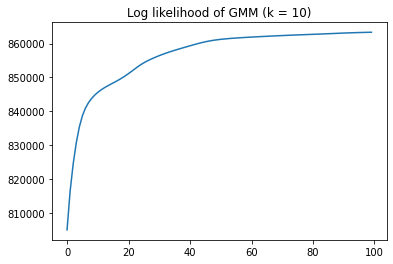

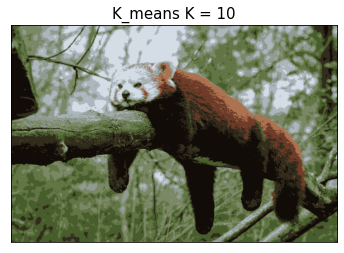

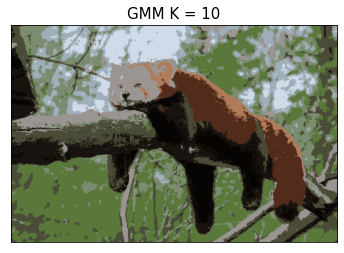

K_means K = 10
     R    G    B
0  212  220  230
1   72   93   44
2   97  117   69
3  144  155  146
4   50   44   28
5  110   60   40
6  172  183  189
7  123  136  101
8  173  115   81
9   17   12    8 

GMM K = 10
     R    G    B
0  207  219  232
1   74   76   55
2   90  120   58
3  158  175  185
4   24   19   14
5   82   43   27
6  155  149  146
7  123  140  113
8  175  123   88
9    7    5    4 



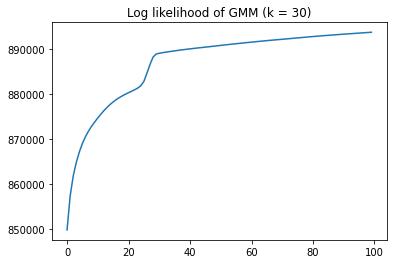

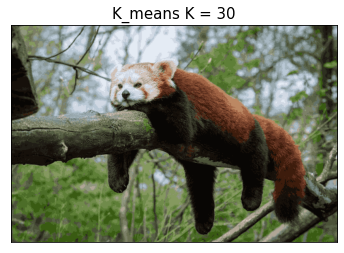

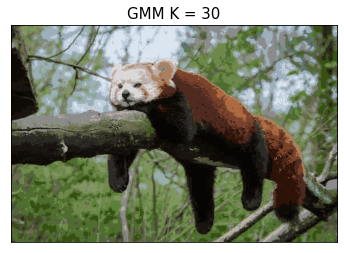

K_means K = 30
      R    G    B
0   106  112   81
1    22   16   10
2   228  235  244
3    88   97   71
4   176  166  150
5    92   47   30
6    99  114  105
7   124  128  103
8   161  100   69
9   209  217  228
10   46   48   32
11  124   70   46
12   62   62   48
13   75   82   56
14  153  169  175
15  144  151  126
16  186  201  214
17   32   29   22
18  188  136   99
19   94  127   55
20    8    6    4
21  133  153   95
22  208  194  184
23  168  184  194
24  112  139   75
25  120  136  131
26   57   91   18
27  139  154  155
28   76  109   40
29   61   28   12 

GMM K = 30
      R    G    B
0   105  106   79
1    14   10    5
2   219  229  240
3    85   99   61
4   139  139  140
5    78   42   32
6    95  114  107
7   120  127  101
8   173  105   65
9   219  216  216
10   43   42   29
11  122   67   43
12   45   43   40
13   74   78   53
14  154  175  173
15  139  147  127
16  192  206  220
17   25   20   15
18  170  129   94
19   92  128   57
20    6    5    4
21  129  149   97


In [ ]:
K_central = [3, 7, 10, 30]
# plot_original_image
plt.title('Original', fontsize = 15)
plt.imshow(img_raw), plt.xticks([]), plt.yticks([])
plt.show()
print('=========================================')
for k in K_central:
    # K-means
    k_means = K_Means(img_array, k, iteration=100)
    k_means.minimize_J_loss(img_array)

    # GMM
    gmm = GMM(k, max_iteration=100)
    gmm.initialize(k_means.rnk, k_means.means, img_array)
    gmm.EM(img_array)
    gmm.plot_log_likelihood()
    
    # plot_result
    plot_img(k_means, k, 'K_means')
    plot_img(gmm, k, 'GMM')
    
    # plot_result
    plot_table(k_means, k, 'K_means')
    plot_table(gmm, k, 'GMM')
  
    print('=========================================')

##[4] Make some discussion about what is crucial factor to affect the output image between K-means and Gaussian mixture model (GMM), and explain the reason.


### Discussion
1. K Means 跟 GMM 都是cluster model.
---
2. 最大的差別是，GMM是有covariance的考量在裡面，其中decision boundary是橢圓形的; K Means的boundary則是圓形的。
---
3. 從上述(2)跟結果來看，可以發現GMM的結果在將浣熊與背景分離上效果比較好，但是在細節毛紋上K means的結果比較好，這跟GMM是soft cluster 利用高斯分佈有關。
---
